In [1]:
# common
import os
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import pydot
import graphviz
import keras
import datetime
# Data
from keras import backend as K


# Clear any logs from previous runs
!rm -rf ./logs/ 
!mkdir ./logs/

print(os.getcwd())

# Data Viz
import matplotlib.pyplot as plt

# Model   
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dense
# Callbacks 
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

%pip install tf_explain
from tf_explain.core.grad_cam import GradCAM

from keras.metrics import MeanIoU


/kaggle/working
Note: you may need to restart the kernel to use updated packages.


In [2]:
SIZE=128
# (0: Neoplastic cells, 1: Inflammatory, 2: Connective/Soft tissue cells, 3: Dead Cells, 4: Epithelial, 6: Background)

def load_image(image):
    return np.round(tf.image.resize(image/255.,(SIZE, SIZE)),4)

def load_images(images):
    images_new=np.zeros((len(images),SIZE,SIZE,3))
    for i in range (len(images)):
        images_new[i]=load_image(images[i])

    print(images_new.shape)
    images=images_new
    del images_new
    return images

def load_labels(labels):
    labels=np.array(pd.get_dummies(labels))
    return labels
    
def load_masks(masks):
    masks=masks[:,:,:,0]+masks[:,:,:,1]+masks[:,:,:,2]+masks[:,:,:,3]+masks[:,:,:,4]
    masks=masks[...,np.newaxis]

    masks_new=np.zeros((len(masks),SIZE,SIZE,1))
    for i in range (len(masks)):
        masks_new[i]=load_image(masks[i])

    print(masks_new.shape)
    masks=masks_new
    masks=tf.cast((masks>0), tf.float32)
    del masks_new
    return masks

def show_image(image, title=None, cmap='coolwarm', alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4,title=None):
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

<!-- # Loading fold 1 of PanNuke dataset -->

# **Loading 1st Dataset**

In [3]:
labels1 = np.load('../input/cancer-inst-segmentation-and-classification/Part 1/Images/types.npy')
labels_name=np.unique(labels1)
labels1 = load_labels(labels1)

In [4]:
images1 = np.load('../input/cancer-inst-segmentation-and-classification/Part 1/Images/images.npy')
images1 = load_images(images1)

(2656, 128, 128, 3)


In [5]:
masks1 = np.load('../input/cancer-inst-segmentation-and-classification/Part 1/Masks/masks.npy')

In [6]:
masks1 = load_masks(masks1)

(2656, 128, 128, 1)


# **Loading 2nd Dataset**

In [7]:
# labels2 = np.load('../input/cancer-instance-segmentation-and-classification-2/Images/types.npy')
# labels2 = load_labels(labels2)

In [8]:
# images2 = np.load('../input/cancer-instance-segmentation-and-classification-2/Images/images.npy')
# images2 = load_images(images2)

(2523, 128, 128, 3)


In [9]:
# masks2 = np.load('../input/cancer-instance-segmentation-and-classification-2/Masks/masks.npy')

In [10]:
# masks2 = load_masks(masks2)

(2523, 128, 128, 1)


# **Loading 3rd Dataset**

In [11]:
# labels3 = np.load('../input/cancer-instance-segmentation-and-classification-3/Images/types.npy')
# labels3 = load_labels(labels3)

In [12]:
# images3 = np.load('../input/cancer-instance-segmentation-and-classification-3/Images/images.npy')
# images3 = load_images(images3)

In [13]:
# masks3 = np.load('../input/cancer-instance-segmentation-and-classification-3/Masks/masks.npy')

In [14]:
# masks3 = load_masks(masks3)

In [15]:
# labels=np.append(labels1,labels2,labels3, axis=0)
# del labels1,labels2,labels2
# masks=np.append(masks1,masks2,masks3, axis=0)
# del masks1,masks2,masks3
# images=np.append(images1,images2,images3,axis=0)
# del images1,images2,images3

labels=np.append(labels1,labels2, axis=0)
del labels1,labels2
masks=np.append(masks1,masks2, axis=0)
del masks1,masks2
images=np.append(images1,images2,axis=0)
del images1,images2

print(labels.shape)
print(labels_name.shape)
print(images.shape)
print(masks.shape)
print(labels_name)


(5179, 19)
(19,)
(5179, 128, 128, 3)
(5179, 128, 128, 1)
['Adrenal_gland' 'Bile-duct' 'Bladder' 'Breast' 'Cervix' 'Colon'
 'Esophagus' 'HeadNeck' 'Kidney' 'Liver' 'Lung' 'Ovarian' 'Pancreatic'
 'Prostate' 'Skin' 'Stomach' 'Testis' 'Thyroid' 'Uterus']


In [ ]:

labels_name=labels_name[:18]
labels=labels[:,:18]
# indexes=[]
# labels_new=[]
# images_new=[]
# masks_new=[]

# for i in range(len(labels_name)):
#     idx=np.argmax(labels,axis=1)==i
    
#     if(np.sum(idx)/MAX_LIM>0.75):
#         indexes=np.append(indexes,i)
#         if labels_new==[]:
#             labels_new = labels[idx][:MAX_LIM]
#             images_new = images[idx][:MAX_LIM]
#             masks_new = masks[idx][:MAX_LIM]
#         else: 
#             labels_new = np.append(labels_new,labels[idx][:MAX_LIM],axis=0)
#             images_new = np.append(images_new,images[idx][:MAX_LIM],axis=0)
#             masks_new =  np.append(masks_new,  masks[idx][:MAX_LIM],axis=0)     


# print(indexes)
# indexes=indexes.astype('uint8')
# labels_new=labels_new[:,indexes]
# labels_name=labels_name[indexes]


# print(labels_new.shape)
# print(labels_name.shape)
# print(images_new.shape)
# print(masks_new.shape)
# print(labels_name)


# labels=labels_new
# del labels_new
# images=images_new
# del images_new
# masks=masks_new
# del masks_new

# print("\n\n")
# print("New Size: ",len(images))
# for i in range(len(labels_name)):
    # subset = masks[np.argmax(labels,axis=1)==i]
    # print("For",labels_name[i],"\tSamples: ",len(subset),"\tScore:",np.sum(subset)/len(subset))/SIZE/SIZE)
    

In [16]:
MAX_LIM=175
labels_name[0]="Adrenal"
print("Old Size: ",len(images))
for i in range(len(labels_name)):
    subset = masks[np.argmax(labels,axis=1)==i]
    print("For",labels_name[i],"\tSamples: ",len(subset),"\tScore:",np.sum(subset)/len(subset))/SIZE/SIZE)


Old Size:  5179
For Adrenal 	Samples:  282 	Score: 0.1385924427221853
For Bile-duct 	Samples:  262 	Score: 0.15442663294668416
For Bladder 	Samples:  82 	Score: 0.15391354444550304
For Breast 	Samples:  1576 	Score: 0.1903568016090974
For Cervix 	Samples:  207 	Score: 0.1964500537817029
For Colon 	Samples:  946 	Score: 0.18739096256441595
For Esophagus 	Samples:  283 	Score: 0.19312666498730124
For HeadNeck 	Samples:  239 	Score: 0.12502400545894352
For Kidney 	Samples:  93 	Score: 0.15076930548555106
For Liver 	Samples:  131 	Score: 0.15232418147662213
For Lung 	Samples:  133 	Score: 0.21274285567434212
For Ovarian 	Samples:  94 	Score: 0.2612492987450133
For Pancreatic 	Samples:  167 	Score: 0.15023968176927396
For Prostate 	Samples:  114 	Score: 0.17560296309621712
For Skin 	Samples:  146 	Score: 0.2376525042808219
For Stomach 	Samples:  98 	Score: 0.22561707788584184
For Testis 	Samples:  139 	Score: 0.17847426160633992
For Thyroid 	Samples:  164 	Score: 0.17179349573647104
For Ute

In [17]:
idx= list(range(len(masks)))
np.random.shuffle(idx)
images=images[idx]
masks=masks[idx]
labels=labels[idx]

print(labels.shape)
print(labels_name.shape)
print(images.shape)
print(masks.shape)
print(labels_name)

(5179, 18)
(18,)
(5179, 128, 128, 3)
(5179, 128, 128, 1)
['Adrenal' 'Bile-duct' 'Bladder' 'Breast' 'Cervix' 'Colon' 'Esophagus'
 'HeadNeck' 'Kidney' 'Liver' 'Lung' 'Ovarian' 'Pancreatic' 'Prostate'
 'Skin' 'Stomach' 'Testis' 'Thyroid']


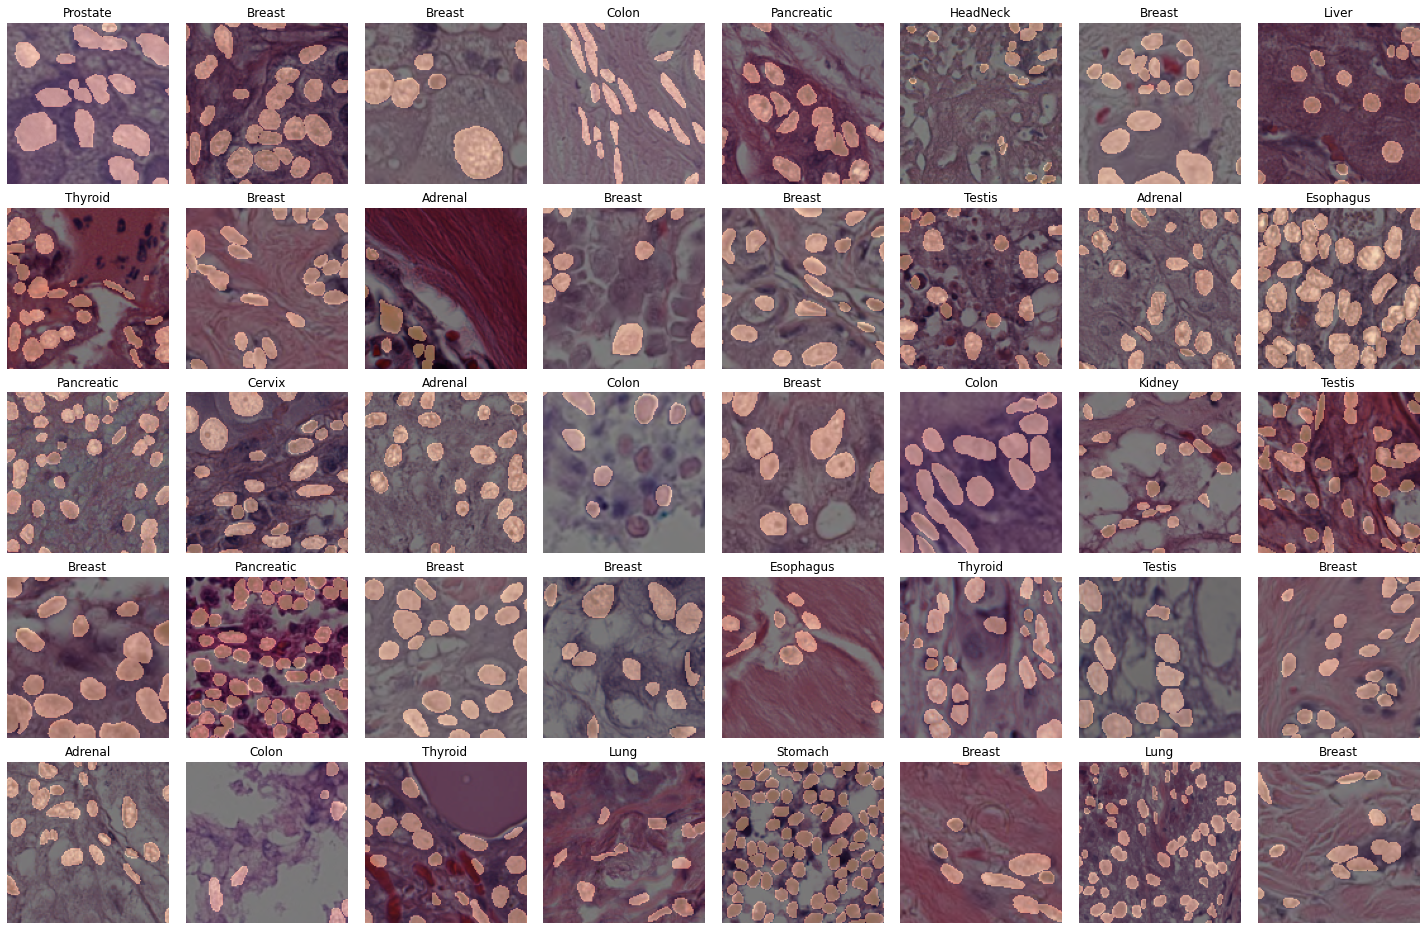

In [18]:
plt.figure(figsize=(20,13))
for i in range(40):
    plt.subplot(5,8,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='copper',title=labels_name[np.argmax(labels[id])],alpha=0.5) # binary afmhot copper

plt.tight_layout()
plt.show()

# **Encoder**

In [19]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
#         x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

# **Decoder**

In [20]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

# **Attention Gate**

In [21]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

# **Loss Functions**

In [22]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) +smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg +(1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)


def jacard_coef_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    IoU=(intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)
    return -IoU


# **Custom Callback**

In [23]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        id = np.random.randint(images.shape[0])
        image = images[id]
        mask = masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])
        exp = GradCAM()
        cam = exp.explain(
            validation_data=(image[np.newaxis,...], mask),
            class_index=1,
            layer_name='Attention4',
            model=self.model
        )

        plt.figure(figsize=(8,6))

        plt.subplot(1,3,1)
        plt.title("Original Mask: "+labels_name[np.argmax(labels[id])])
        show_mask(image, mask, cmap='copper',alpha=0.5)

        plt.subplot(1,3,2)
        plt.title("Predicted Mask: ")
        show_mask(image, pred_mask, cmap='copper',alpha=0.5)

        plt.subplot(1,3,3)
        show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()

# **Attention UNet**

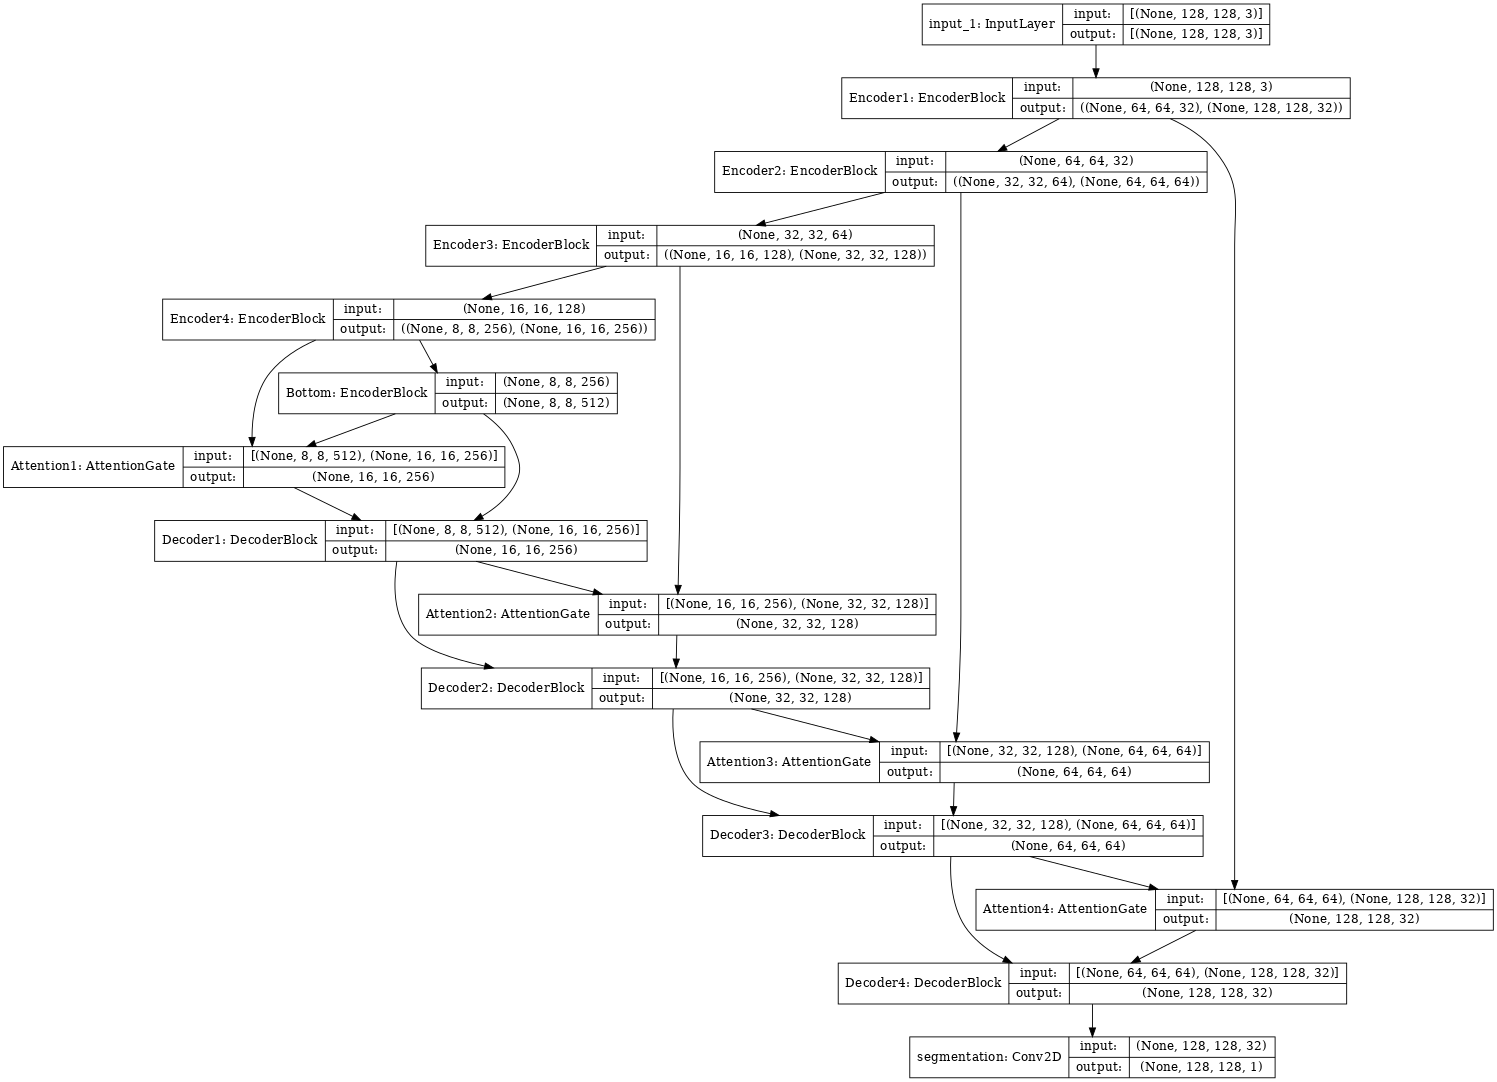

In [24]:
# Inputs
input_layer = Input(shape=images.shape[-3:])

# Encoder
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Bottom")(p4)

# Attention + Decoder
a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])

a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output 

output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same',name="segmentation")(d4)

# Model
model = Model(
    inputs=[input_layer],
    outputs=output_layer
)

# Compile
model.compile(
    loss=jacard_coef_loss,
    optimizer=tf.optimizers.Adam(), 
    metrics=[tversky,dice_coef],
)


# Callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# EarlyStopping(patience=3, restore_best_weight=True),

model.load_weights("/kaggle/input/onlysegmentationweightsh5/OnlySegmentationWeights.h5")
cb = [
    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True),
     ShowProgress(),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]

# model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64, expand_nested=True)

# **Training**

Epoch 1/25
20/20 [==============================] - 39s 1s/step - loss: -0.6357 - tversky: 0.7936 - dice_coef: 0.7764 - val_loss: -0.5649 - val_tversky: 0.7631 - val_dice_coef: 0.7578


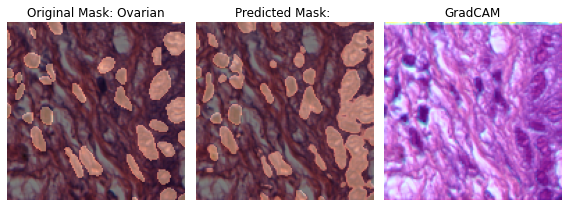

Epoch 2/25
20/20 [==============================] - 16s 791ms/step - loss: -0.6895 - tversky: 0.8294 - dice_coef: 0.8167 - val_loss: -0.6635 - val_tversky: 0.8366 - val_dice_coef: 0.8113


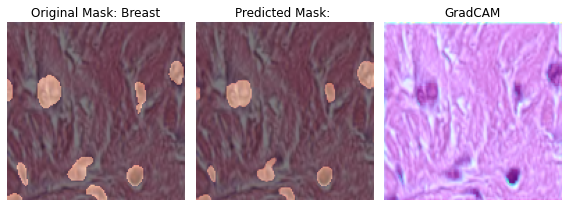

Epoch 3/25
20/20 [==============================] - 16s 791ms/step - loss: -0.7029 - tversky: 0.8379 - dice_coef: 0.8248 - val_loss: -0.6701 - val_tversky: 0.8452 - val_dice_coef: 0.8106


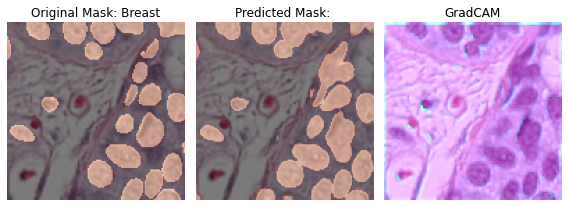

Epoch 4/25
20/20 [==============================] - 16s 787ms/step - loss: -0.7099 - tversky: 0.8425 - dice_coef: 0.8305 - val_loss: -0.6264 - val_tversky: 0.8321 - val_dice_coef: 0.7773


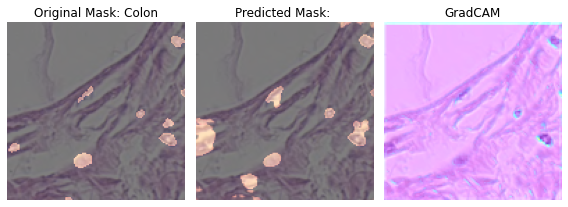

Epoch 5/25
20/20 [==============================] - 16s 789ms/step - loss: -0.7136 - tversky: 0.8450 - dice_coef: 0.8326 - val_loss: -0.6756 - val_tversky: 0.8206 - val_dice_coef: 0.8147


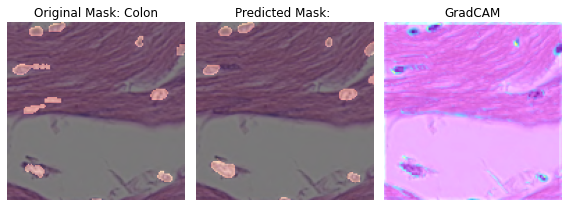

Epoch 6/25
20/20 [==============================] - 16s 792ms/step - loss: -0.7189 - tversky: 0.8486 - dice_coef: 0.8365 - val_loss: -0.6909 - val_tversky: 0.8422 - val_dice_coef: 0.8224


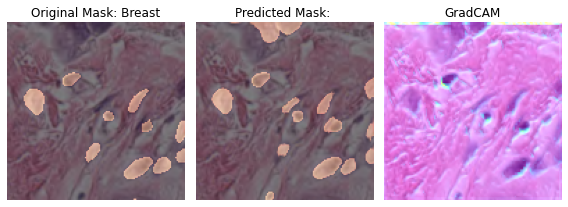

Epoch 7/25
20/20 [==============================] - 16s 793ms/step - loss: -0.7220 - tversky: 0.8499 - dice_coef: 0.8385 - val_loss: -0.7003 - val_tversky: 0.8384 - val_dice_coef: 0.8271


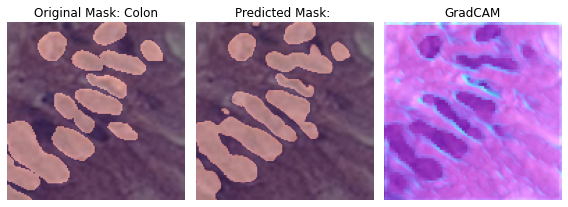

Epoch 8/25
20/20 [==============================] - 16s 796ms/step - loss: -0.7230 - tversky: 0.8512 - dice_coef: 0.8391 - val_loss: -0.6981 - val_tversky: 0.8434 - val_dice_coef: 0.8300


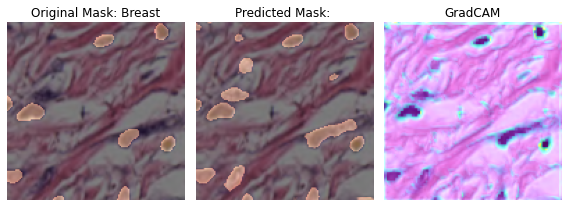

Epoch 9/25
20/20 [==============================] - 16s 791ms/step - loss: -0.7281 - tversky: 0.8541 - dice_coef: 0.8426 - val_loss: -0.6982 - val_tversky: 0.8570 - val_dice_coef: 0.8248


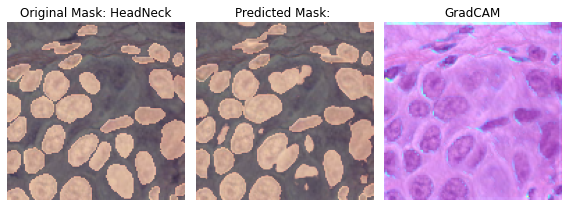

Epoch 10/25
20/20 [==============================] - 16s 786ms/step - loss: -0.7334 - tversky: 0.8572 - dice_coef: 0.8460 - val_loss: -0.7103 - val_tversky: 0.8423 - val_dice_coef: 0.8363


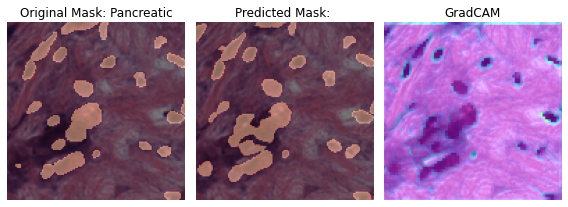

Epoch 11/25
20/20 [==============================] - 16s 795ms/step - loss: -0.7350 - tversky: 0.8576 - dice_coef: 0.8467 - val_loss: -0.7004 - val_tversky: 0.8334 - val_dice_coef: 0.8311


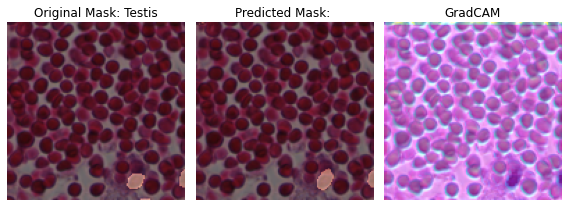

Epoch 12/25
20/20 [==============================] - 16s 795ms/step - loss: -0.7403 - tversky: 0.8610 - dice_coef: 0.8507 - val_loss: -0.7175 - val_tversky: 0.8524 - val_dice_coef: 0.8396


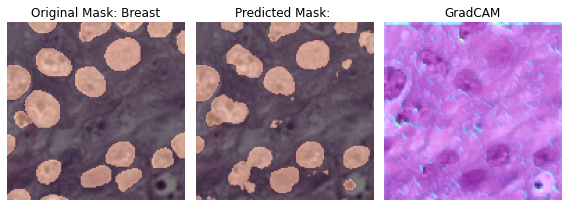

Epoch 13/25
20/20 [==============================] - 16s 793ms/step - loss: -0.7409 - tversky: 0.8618 - dice_coef: 0.8512 - val_loss: -0.7217 - val_tversky: 0.8529 - val_dice_coef: 0.8390


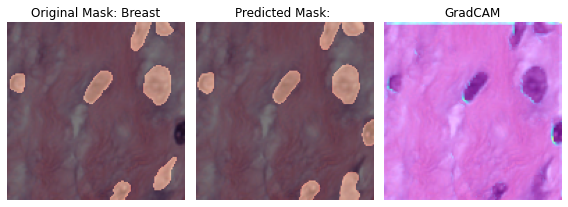

Epoch 14/25
20/20 [==============================] - 16s 793ms/step - loss: -0.7461 - tversky: 0.8649 - dice_coef: 0.8548 - val_loss: -0.7164 - val_tversky: 0.8440 - val_dice_coef: 0.8392


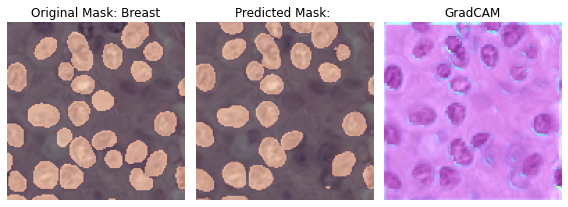

Epoch 15/25
20/20 [==============================] - 16s 795ms/step - loss: -0.7473 - tversky: 0.8664 - dice_coef: 0.8559 - val_loss: -0.7198 - val_tversky: 0.8557 - val_dice_coef: 0.8378


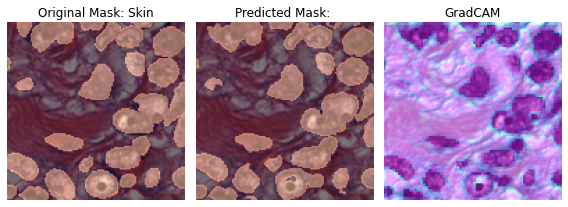

Epoch 16/25
20/20 [==============================] - 16s 790ms/step - loss: -0.7499 - tversky: 0.8668 - dice_coef: 0.8573 - val_loss: -0.7058 - val_tversky: 0.8662 - val_dice_coef: 0.8299


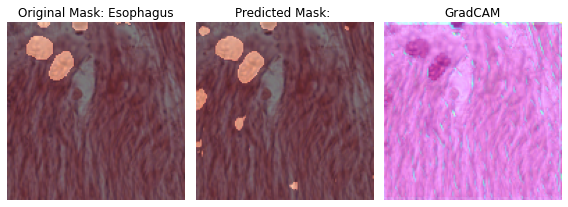

Epoch 17/25
20/20 [==============================] - 16s 795ms/step - loss: -0.7484 - tversky: 0.8666 - dice_coef: 0.8557 - val_loss: -0.7195 - val_tversky: 0.8424 - val_dice_coef: 0.8416


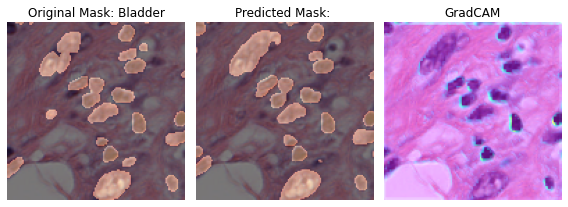

Epoch 18/25
20/20 [==============================] - 16s 788ms/step - loss: -0.7528 - tversky: 0.8689 - dice_coef: 0.8592 - val_loss: -0.7238 - val_tversky: 0.8556 - val_dice_coef: 0.8427


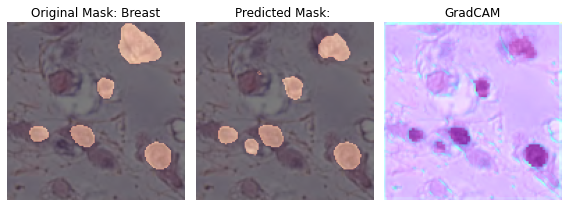

Epoch 19/25
20/20 [==============================] - 15s 791ms/step - loss: -0.7571 - tversky: 0.8703 - dice_coef: 0.8618 - val_loss: -0.7156 - val_tversky: 0.8562 - val_dice_coef: 0.8400


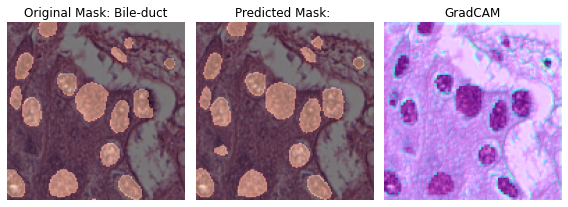

Epoch 20/25
20/20 [==============================] - 16s 799ms/step - loss: -0.7581 - tversky: 0.8716 - dice_coef: 0.8616 - val_loss: -0.7244 - val_tversky: 0.8612 - val_dice_coef: 0.8414


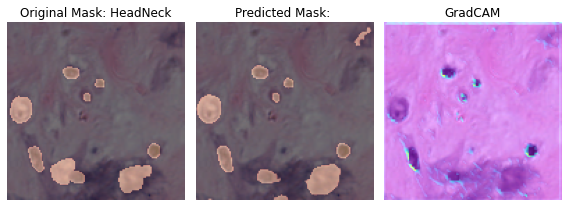

Epoch 21/25
20/20 [==============================] - 16s 793ms/step - loss: -0.7594 - tversky: 0.8718 - dice_coef: 0.8628 - val_loss: -0.7178 - val_tversky: 0.8651 - val_dice_coef: 0.8369


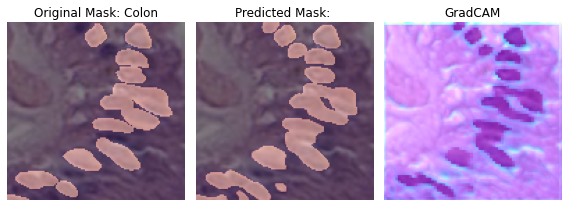

Epoch 22/25
20/20 [==============================] - 16s 783ms/step - loss: -0.7654 - tversky: 0.8772 - dice_coef: 0.8674 - val_loss: -0.7226 - val_tversky: 0.8422 - val_dice_coef: 0.8426


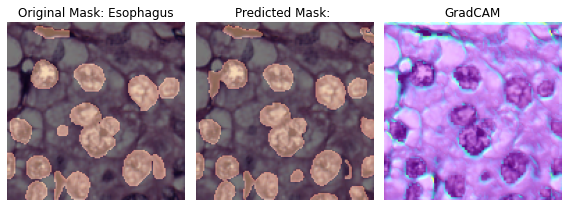

Epoch 23/25
20/20 [==============================] - 16s 795ms/step - loss: -0.7680 - tversky: 0.8775 - dice_coef: 0.8691 - val_loss: -0.7191 - val_tversky: 0.8668 - val_dice_coef: 0.8386


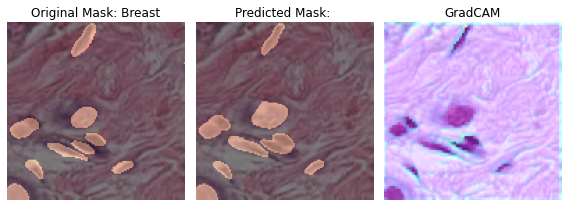

Epoch 24/25
20/20 [==============================] - 12s 585ms/step - loss: -0.7709 - tversky: 0.8800 - dice_coef: 0.8709 - val_loss: -0.7166 - val_tversky: 0.8642 - val_dice_coef: 0.8363


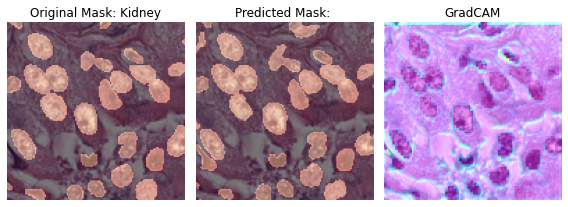

In [25]:
# Config Training
with tf.device('/device:GPU:0'):
    BATCH_SIZE = 256
    SPE = len(images)//BATCH_SIZE

    # Training
    results = model.fit(
      images, masks,
      epochs=25,
      steps_per_epoch=SPE,
      batch_size=BATCH_SIZE,
      callbacks=cb,
      validation_split=0.1
    )

In [26]:
model.save_weights("Segmentation.h5")

# **Evaluation**

In [27]:
# loss,segmentation_loss,prediction_loss,segmentation_accuracy,segmentation_IoU,prediction_accuracy,\
# val_loss,val_segmentation_loss,val_prediction_loss,val_segmentation_accuracy,val_segmentation_IoU,val_prediction_accuracy=
loss,tversky,dice_coef,val_loss,val_tversky,val_dice_coef=results.history.values()

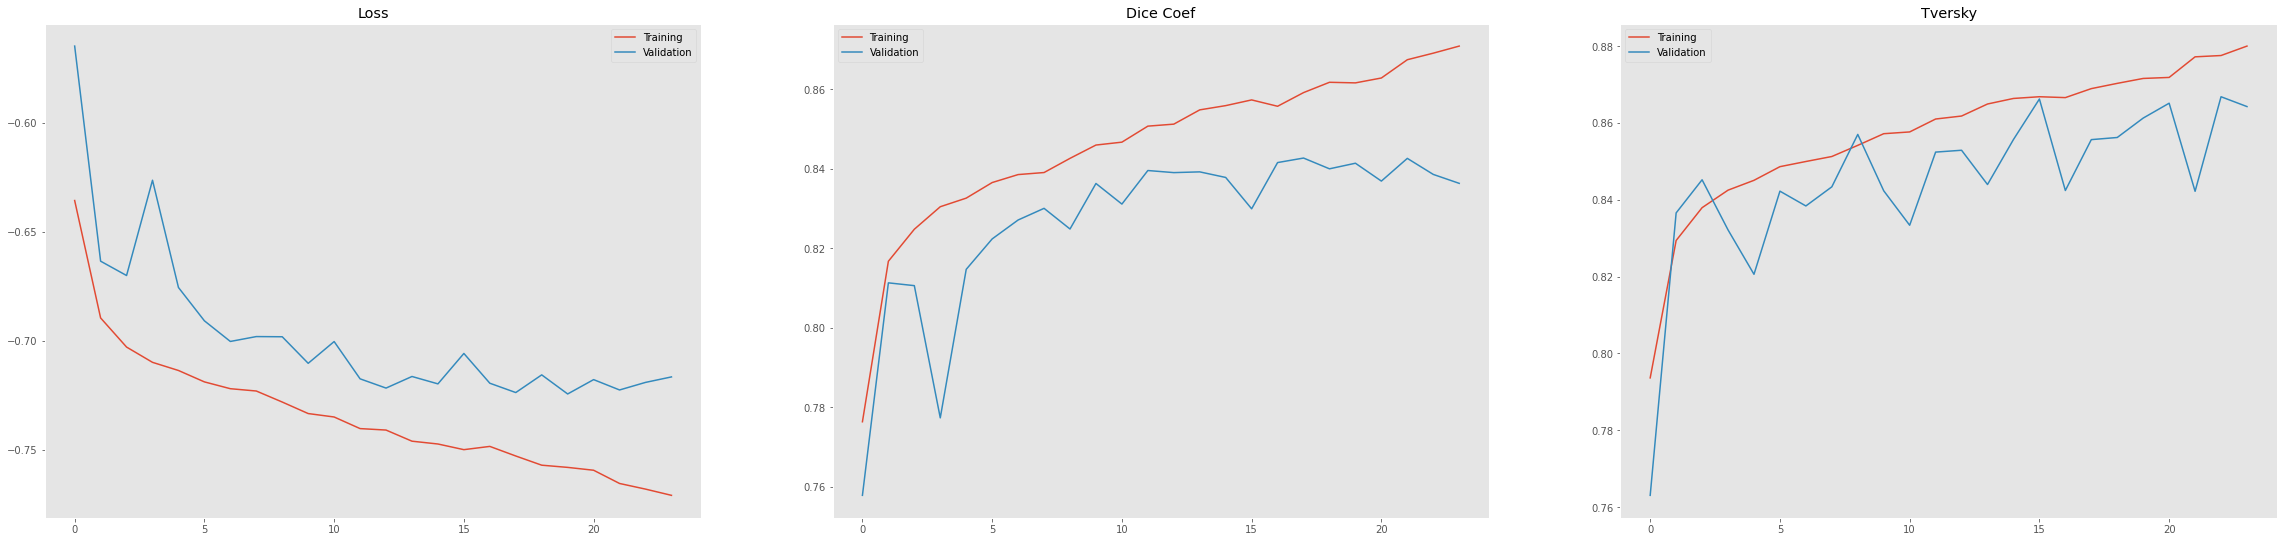

In [28]:
plt.figure(figsize=(40,20))
plt.style.use("ggplot")

plt.subplot(2,3,1)
plt.title("Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validation")
plt.legend()
plt.grid()

plt.subplot(2,3,2)
plt.title("Dice Coef")
plt.plot(dice_coef, label="Training")
plt.plot(val_dice_coef, label="Validation")
plt.legend()
plt.grid()

plt.subplot(2,3,3)
plt.title("Tversky")
plt.plot(tversky, label="Training")
plt.plot(val_tversky, label="Validation")
plt.legend()
plt.grid()


# plt.subplot(2,3,4)
# plt.title("Model IoU")
# plt.plot(segmentation_IoU, label="Training")
# plt.plot(val_segmentation_IoU, label="Validation")
# plt.legend()
# plt.grid()

# plt.subplot(2,3,5)
# plt.title("Segmentation Accuracy")
# plt.plot(segmentation_accuracy, label="Training")
# plt.plot(val_segmentation_accuracy, label="Validation")
# plt.legend()
# plt.grid()

# plt.subplot(2,3,6)
# plt.title("Classification Accuracy")
# plt.plot(prediction_accuracy, label="Training")
# plt.plot(val_prediction_accuracy, label="Validation")
# plt.legend()
# plt.grid()


plt.show()

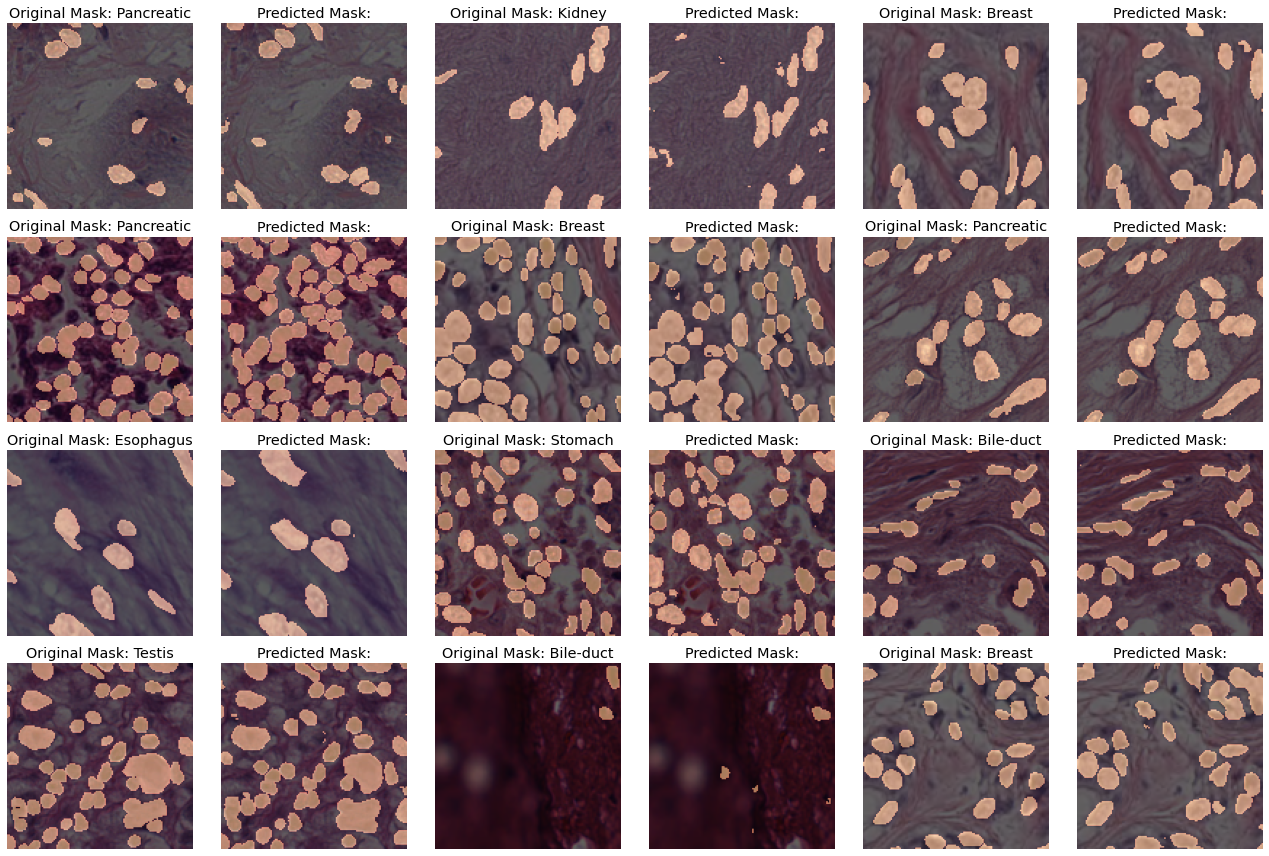

In [29]:
plt.figure(figsize=(18,12))
n=0
for i in range(1,(4*6)+1):
    plt.subplot(4,6,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])
        show_mask(image, mask,title="Original Mask: "+labels_name[np.argmax(labels[id])],alpha=0.6, cmap='copper')
        n+=1
    elif n==1:
        show_mask(image, tf.cast(pred_mask>0.5,tf.float32), title="Predicted Mask:",alpha=0.6,cmap='copper')
        n+=1
    
    elif n==2:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])
        show_mask(image, mask,title="Original Mask: "+labels_name[np.argmax(labels[id])],alpha=0.6, cmap='copper')
        n+=1
    elif n==3:
        show_mask(image, tf.cast(pred_mask>0.5,tf.float32), title="Predicted Mask:",alpha=0.6,cmap='copper')
        n+=1
        
    elif n==4:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])
        show_mask(image, mask,title="Original Mask: "+labels_name[np.argmax(labels[id])],alpha=0.6, cmap='copper')
        n+=1
    else:
        show_mask(image, tf.cast(pred_mask>0.5,tf.float32), title="Predicted Mask:",alpha=0.6,cmap='copper')
        n=0
    
plt.tight_layout()
plt.show()